=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27528 entries, 0 to 27527
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               27528 non-null  object 
 1   age                  27528 non-null  float64
 2   hypertension         27528 non-null  int64  
 3   heart_disease        27528 non-null  int64  
 4   smoking_history      27528 non-null  object 
 5   bmi                  27528 non-null  float64
 6   HbA1c_level          27528 non-null  float64
 7   blood_glucose_level  27528 non-null  int64  
 8   diabetes             27528 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 1.9+ MB

=== First 5 Rows ===
    gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0          

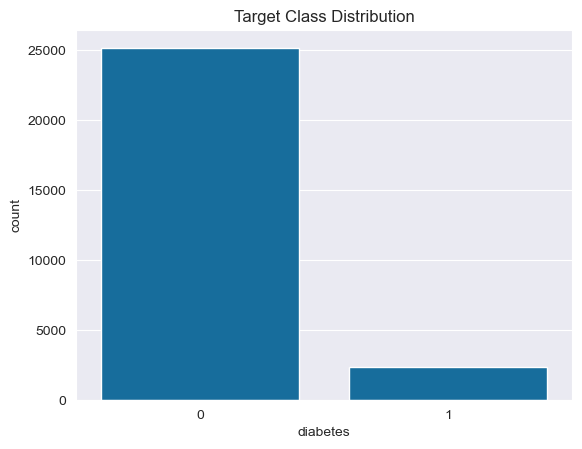

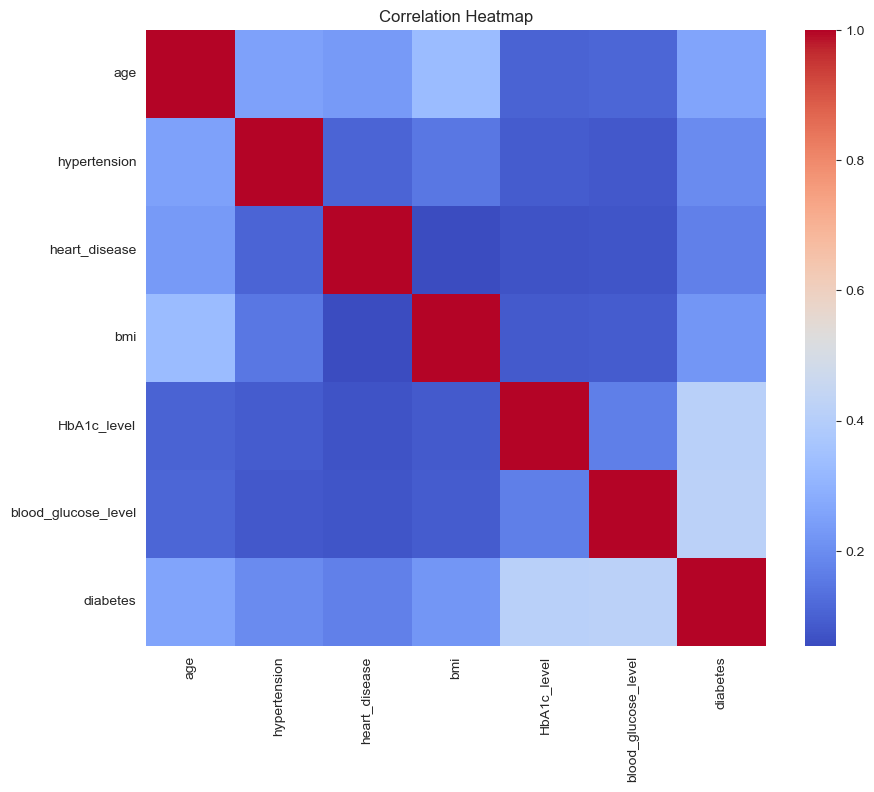

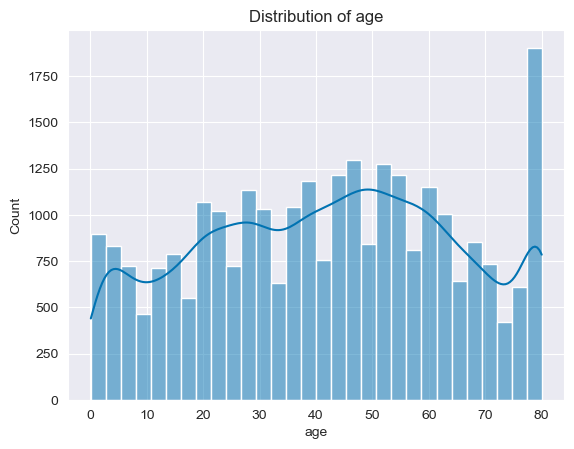

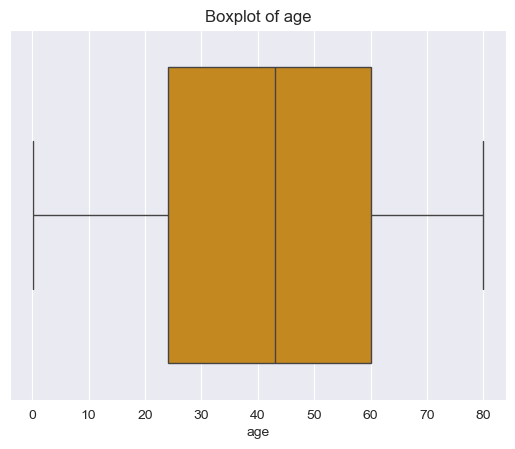

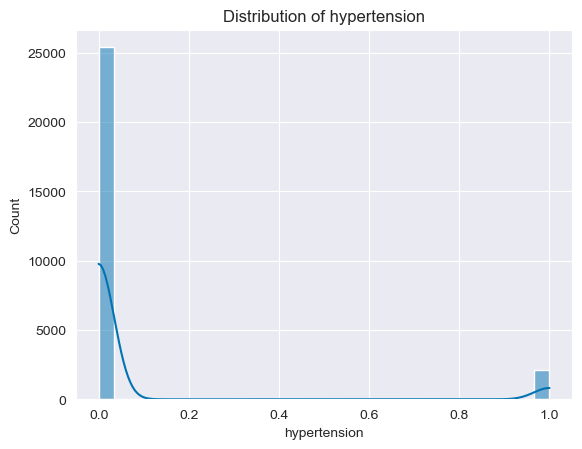

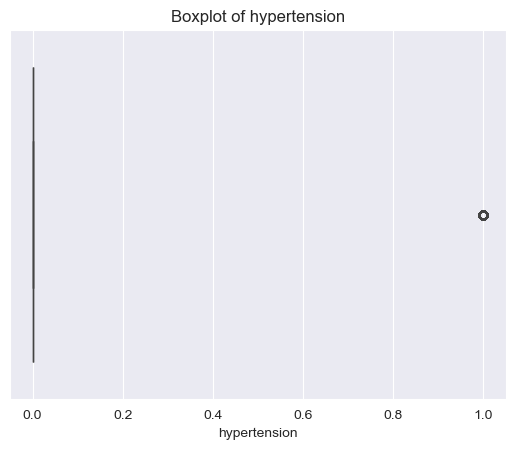

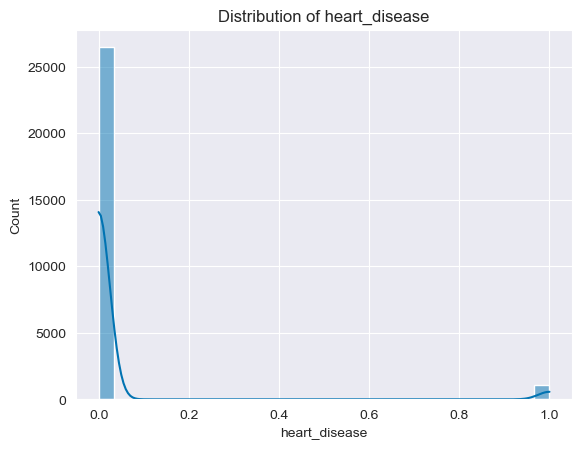

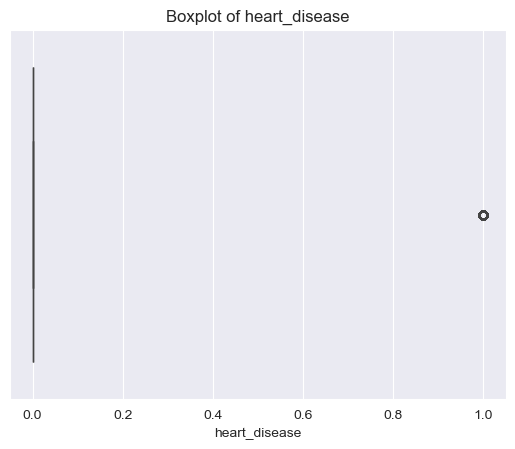

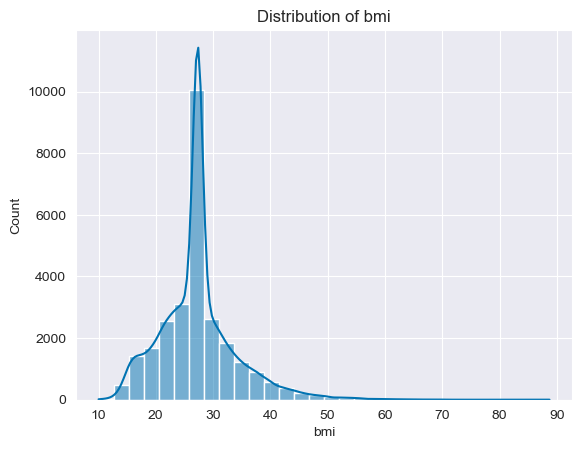

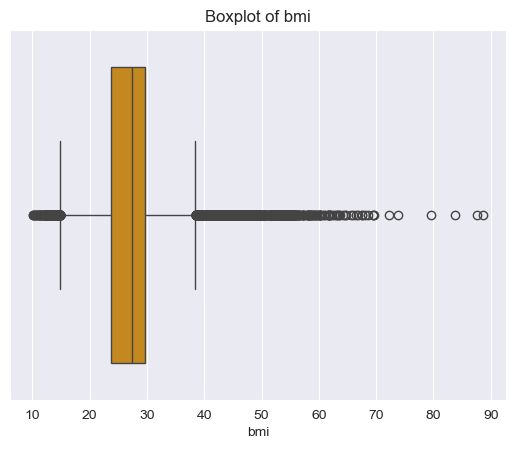

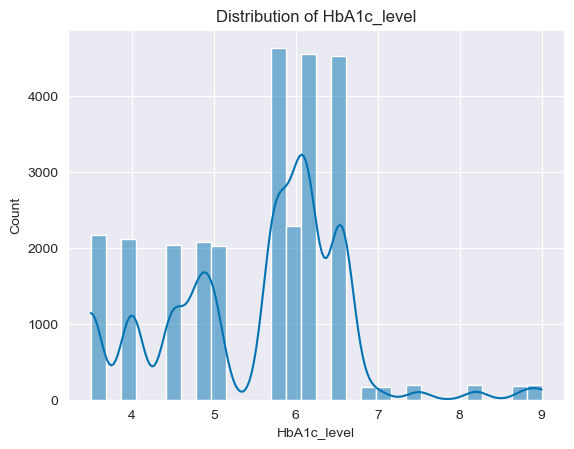

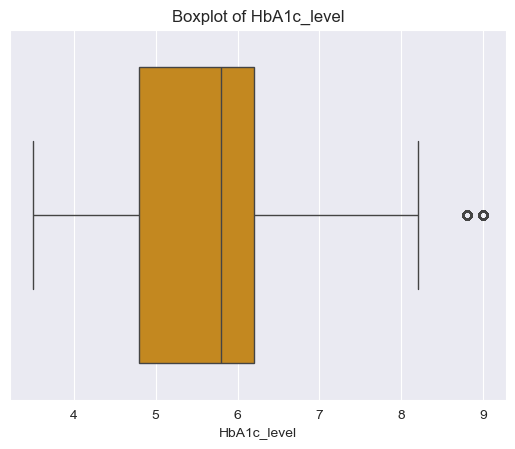

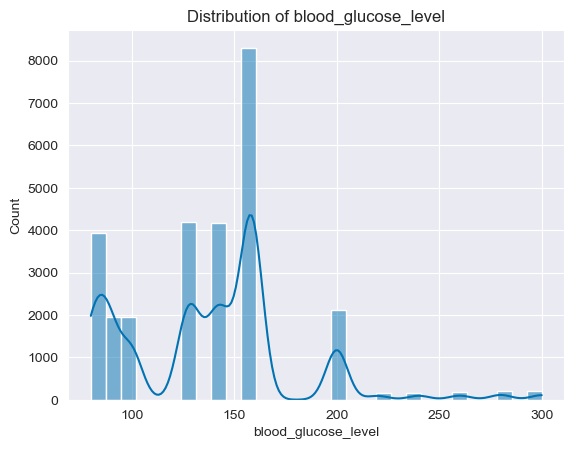

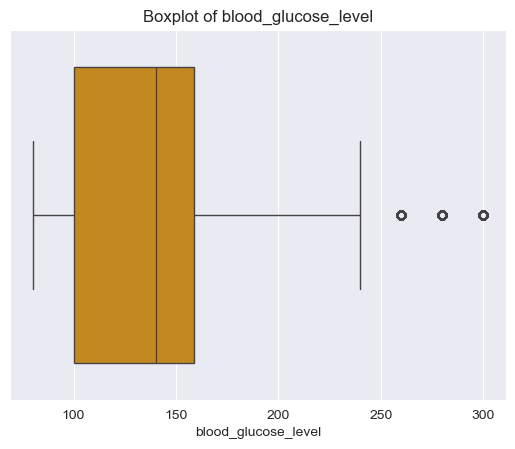

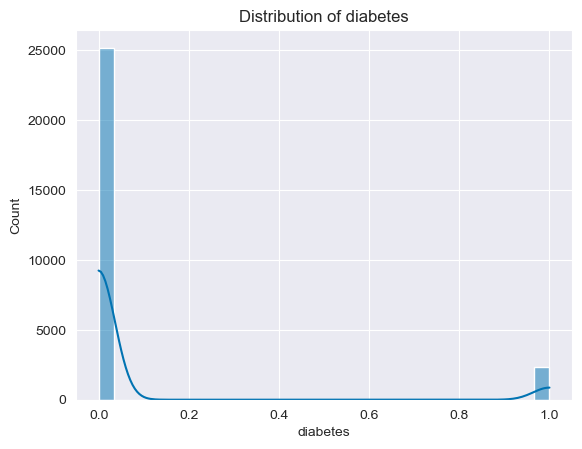

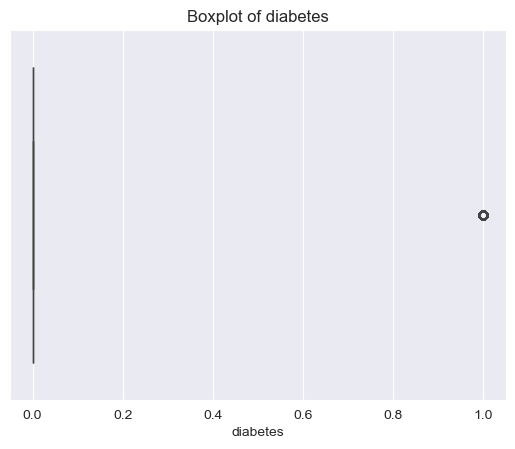

C:\Users\dylan\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


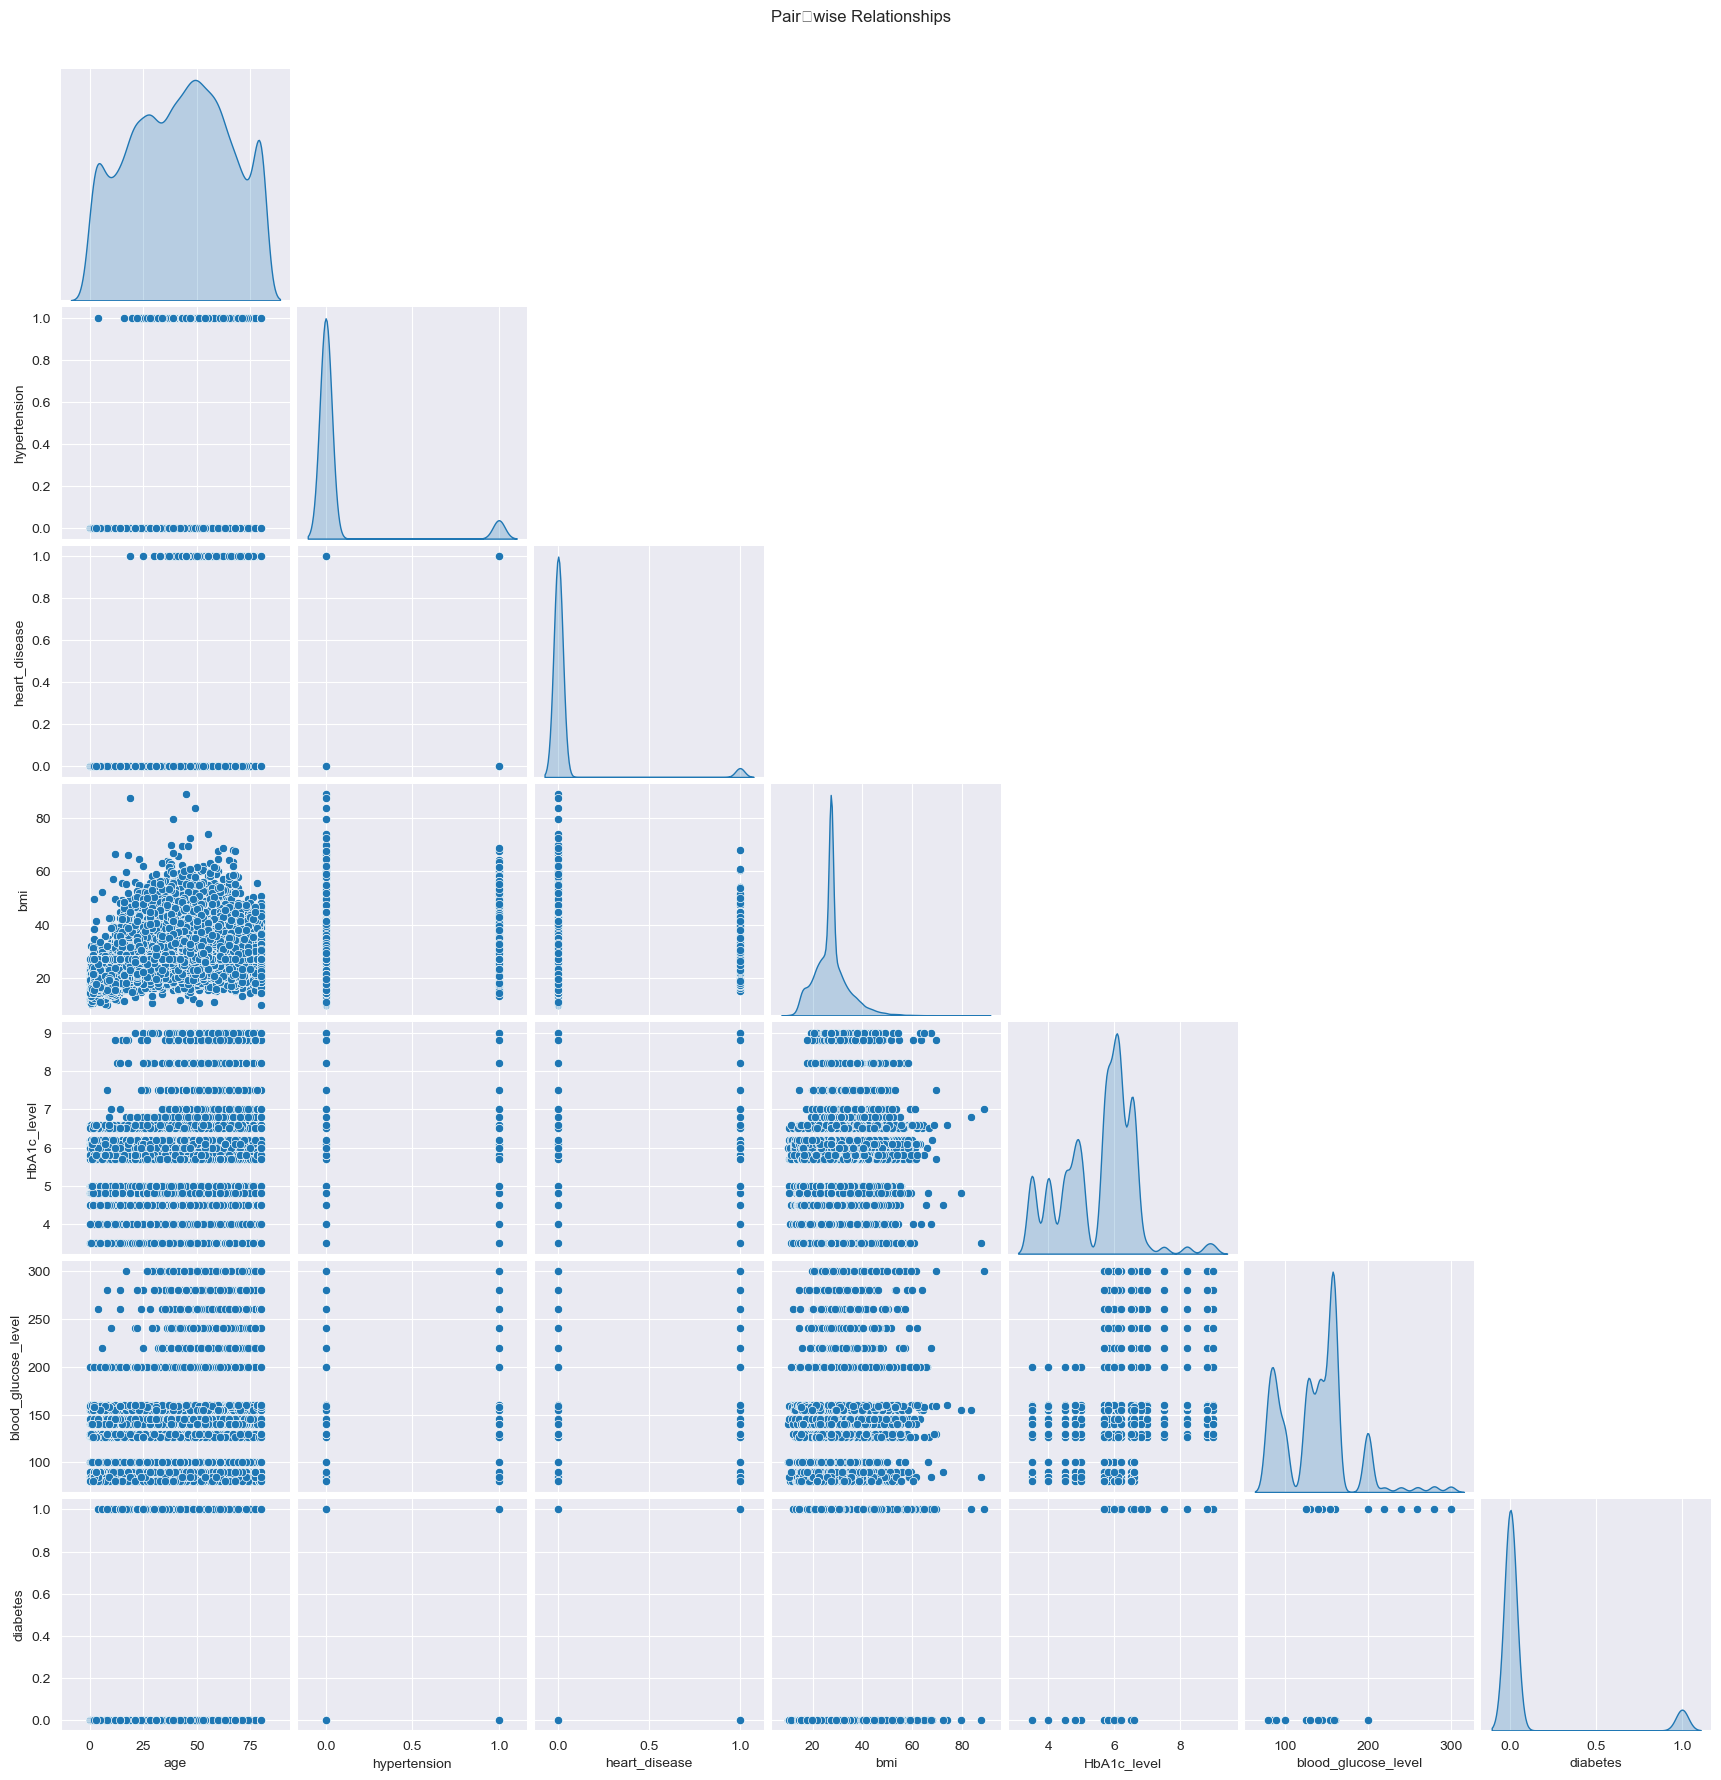


=== Mean Values by Target ===
                 age  hypertension  heart_disease        bmi  HbA1c_level  \
diabetes                                                                   
0         40.226821      0.061268       0.028647  26.913819      5.38903   
1         60.975424      0.247034       0.147034  32.233089      6.96822   

          blood_glucose_level  diabetes  
diabetes                                 
0                  132.776144       0.0  
1                  193.928814       1.0  


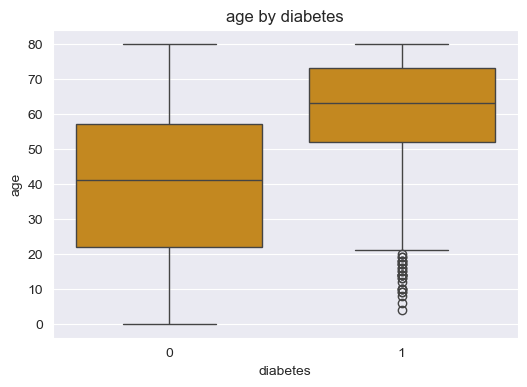

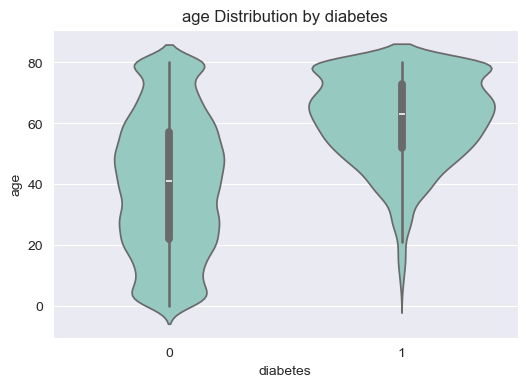

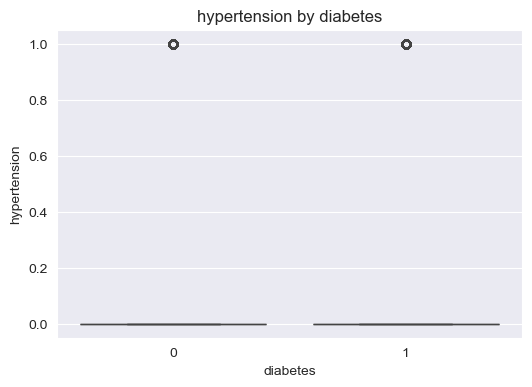

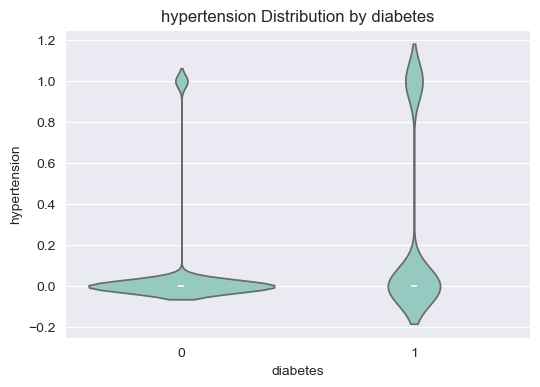

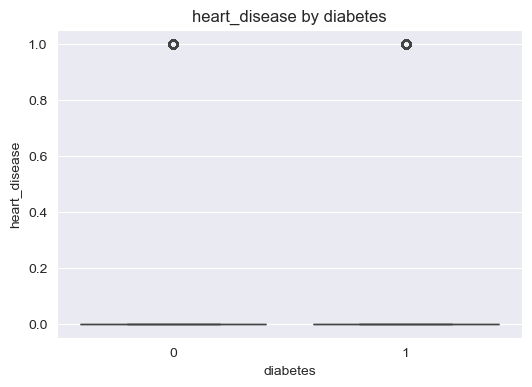

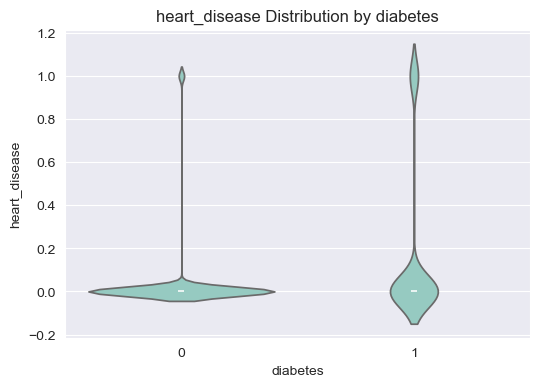

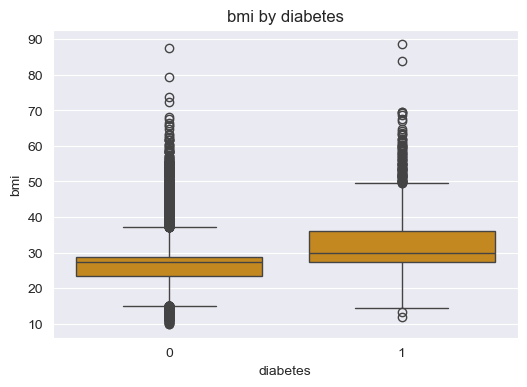

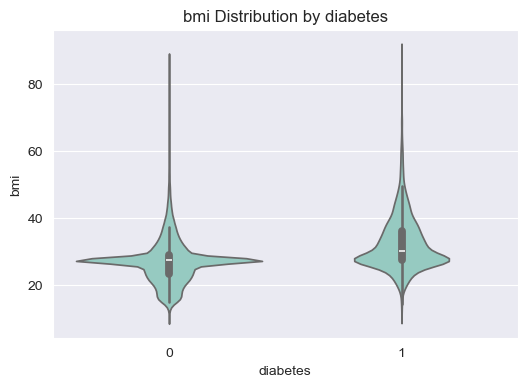

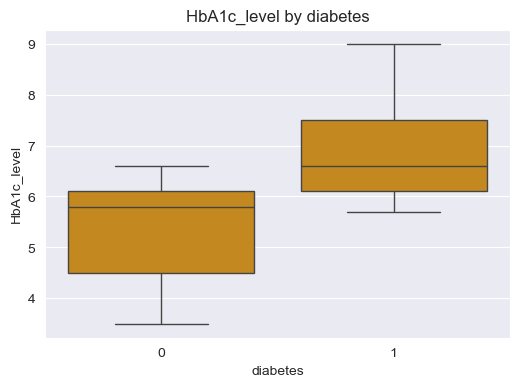

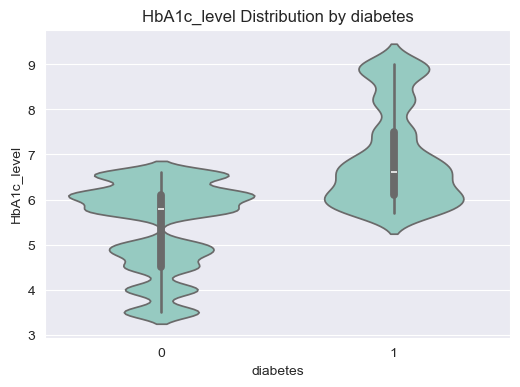

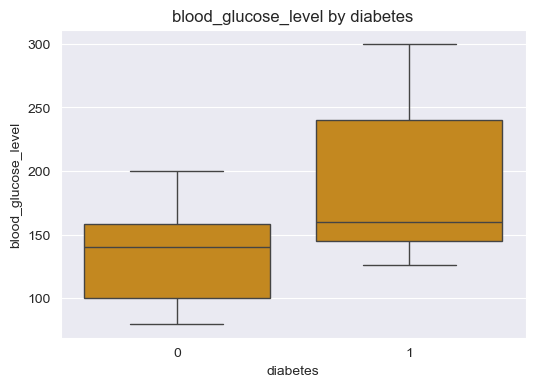

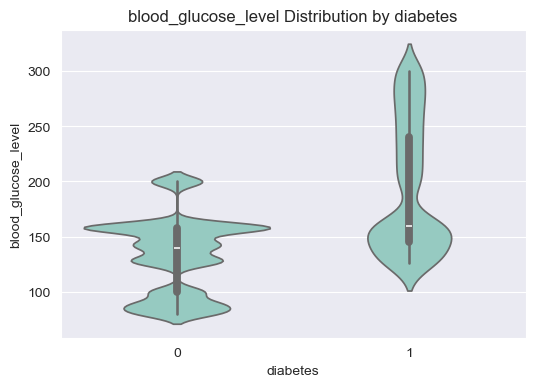

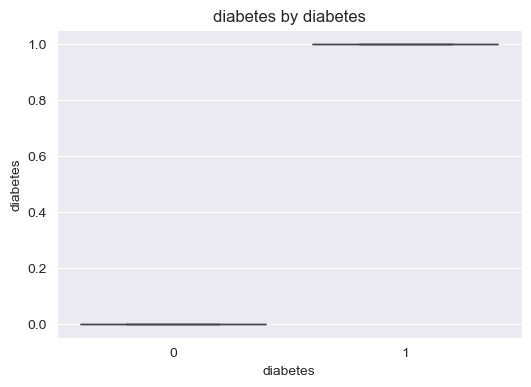

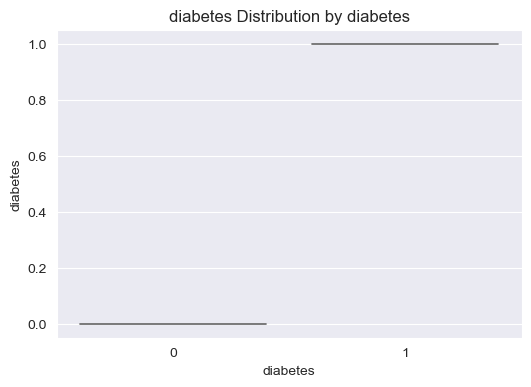


=== Value Counts for gender ===
gender
Female    16178
Male      11345
Other         5
Name: count, dtype: int64


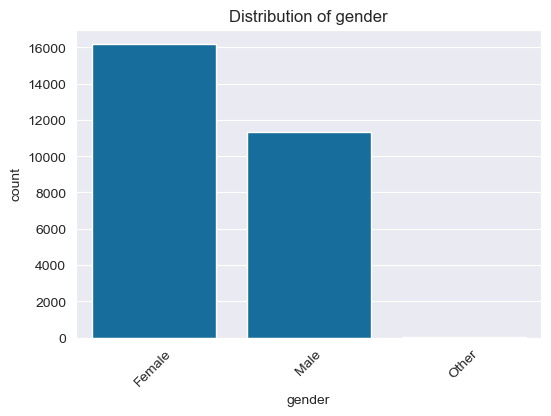

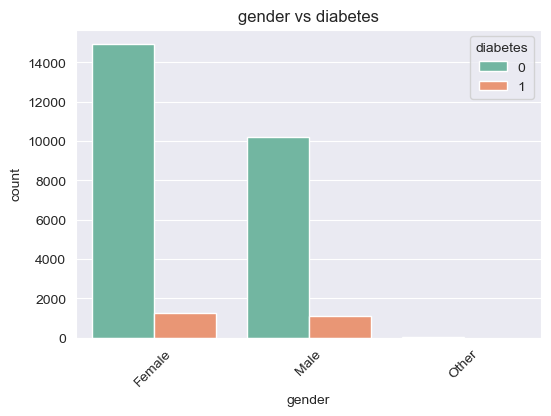

Chi‑Square gender vs diabetes: χ²=38.08, p=5.389e-09

=== Value Counts for smoking_history ===
smoking_history
never          9799
No Info        9723
former         2635
current        2540
not current    1746
ever           1085
Name: count, dtype: int64


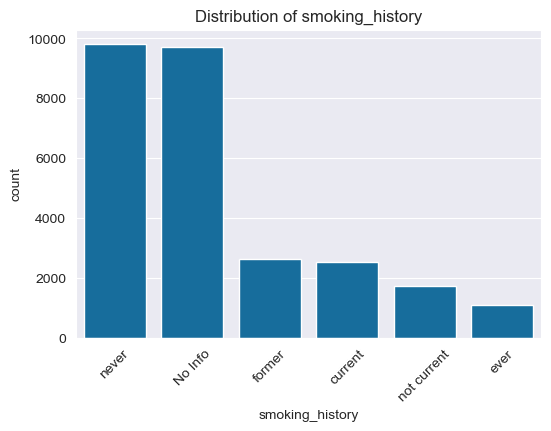

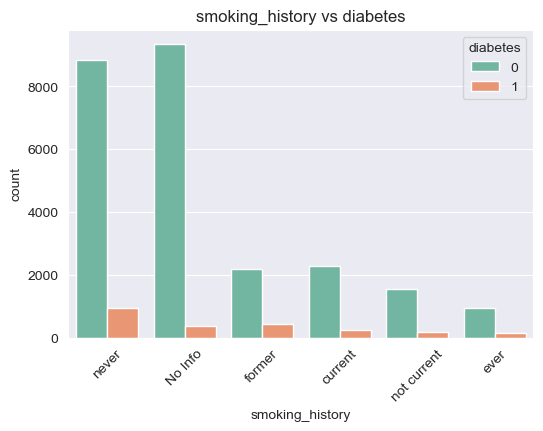

Chi‑Square smoking_history vs diabetes: χ²=556.48, p=5.095e-118

EDA complete


In [1]:
"""
Exploratory‑Data‑Analysis (EDA) for the Diabetes‑Prediction dataset
-------------------------------------------------------------------
 * summary stats, missing‑value scan, class balance
 * numeric correlations, histograms, boxplots, pair‑plots
 * categorical counts & χ² tests
-------------------------------------------------------------------
Author: Dylan Jay
"""

# ──────────────────────────  IMPORTS  ──────────────────────────────
from pathlib import Path
from typing  import List, Optional

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# ──────────────────────────  CONFIG  ───────────────────────────────
DATA_PATH  = Path(r"C:\Users\dylan\Desktop\Data Science Final\diabetes_prediction_dataset.csv")
TARGET_COL = "diabetes"

# plotting
SAVE_FIGS   = False                     # True ⇒ figures saved to ./eda_figs
FIG_DIR     = Path("eda_figs")
STYLE       = "darkgrid"
PALETTE     = "colorblind"

PAIRPLOT_MAX_NUMERIC = 10               # safety cap

# ──────────────────────────  HELPERS  ──────────────────────────────
def _maybe_save(fig: plt.Figure, name: str) -> None:
    if SAVE_FIGS:
        FIG_DIR.mkdir(exist_ok=True)
        fig.savefig(FIG_DIR / f"{name}.png", dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)


def basic_overview(df: pd.DataFrame) -> None:
    print("=== Basic Info ===");  df.info()
    print("\n=== First 5 Rows ===\n", df.head())
    print("\n=== Summary Statistics ===\n", df.describe(include="all"))
    print("\n=== Missing Values ===\n", df.isnull().sum())
    print("\n=== Unique Values per Column ===\n", df.nunique())


def show_class_balance(df: pd.DataFrame, target: str) -> None:
    if target not in df.columns:
        return
    print("\n=== Target Class Balance ===")
    print(df[target].value_counts(normalize=True))

    fig, ax = plt.subplots()
    sns.countplot(x=target, data=df,
                  color=sns.color_palette(PALETTE)[0], ax=ax)   # <─ single colour
    ax.set_title("Target Class Distribution")
    _maybe_save(fig, "target_class_balance")


def corr_heatmap(df: pd.DataFrame) -> pd.DataFrame:
    num_df = df.select_dtypes("number").loc[:, df.nunique() > 1]
    corr   = num_df.corr(numeric_only=True)

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", ax=ax)
    ax.set_title("Correlation Heatmap")
    _maybe_save(fig, "correlation_heatmap")
    return num_df


def plot_distributions(num_df: pd.DataFrame) -> None:
    for col in num_df.columns:
        fig, ax = plt.subplots()
        sns.histplot(num_df[col], kde=True, bins=30,
                     ax=ax, color=sns.color_palette(PALETTE)[0])
        ax.set_title(f"Distribution of {col}")
        _maybe_save(fig, f"hist_{col}")

        fig2, ax2 = plt.subplots()
        sns.boxplot(x=num_df[col], ax=ax2,
                    color=sns.color_palette(PALETTE)[1])
        ax2.set_title(f"Boxplot of {col}")
        _maybe_save(fig2, f"box_{col}")


def pair_plot(df: pd.DataFrame, num_df: pd.DataFrame) -> None:
    if len(num_df.columns) <= PAIRPLOT_MAX_NUMERIC:
        sns.pairplot(df[num_df.columns], diag_kind="kde", corner=True)
        plt.suptitle("Pair‑wise Relationships", y=1.02)
        _maybe_save(plt.gcf(), "pairplot")


def categorical_analysis(df: pd.DataFrame, target: str) -> None:
    cat_cols = df.select_dtypes("object").columns
    for col in cat_cols:
        print(f"\n=== Value Counts for {col} ===")
        print(df[col].value_counts())

        # distribution
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.countplot(x=col, data=df,
                      order=df[col].value_counts().index,
                      color=sns.color_palette(PALETTE)[0], ax=ax)
        ax.set_title(f"Distribution of {col}")
        ax.tick_params(axis="x", rotation=45)
        _maybe_save(fig, f"count_{col}")

        # relation to target
        if target in df.columns:
            fig2, ax2 = plt.subplots(figsize=(6, 4))
            sns.countplot(x=col, hue=target, data=df,
                          order=df[col].value_counts().index,
                          palette="Set2", ax=ax2)          # hue present ⇒ palette OK
            ax2.set_title(f"{col} vs {target}")
            ax2.tick_params(axis="x", rotation=45)
            _maybe_save(fig2, f"{col}_vs_target")

            contingency = pd.crosstab(df[col], df[target])
            chi2, p, *_ = chi2_contingency(contingency)
            print(f"Chi‑Square {col} vs {target}: χ²={chi2:.2f}, p={p:.5g}")


def numeric_by_target(df: pd.DataFrame, target: str,
                      num_cols: Optional[List[str]] = None) -> None:
    if target not in df.columns:
        return
    if num_cols is None:
        num_cols = df.select_dtypes("number").columns.tolist()

    print("\n=== Mean Values by Target ===\n",
          df.groupby(target)[num_cols].mean())

    for col in num_cols:
        # boxplot
        fig1, ax1 = plt.subplots(figsize=(6, 4))
        sns.boxplot(x=target, y=col, data=df,
                    color=sns.color_palette(PALETTE)[1], ax=ax1)
        ax1.set_title(f"{col} by {target}")
        _maybe_save(fig1, f"box_{col}_by_target")

        # violin
        fig2, ax2 = plt.subplots(figsize=(6, 4))
        sns.violinplot(x=target, y=col, data=df,
                       color=sns.color_palette("Set3")[0], ax=ax2)
        ax2.set_title(f"{col} Distribution by {target}")
        _maybe_save(fig2, f"violin_{col}_by_target")


# ──────────────────────────  MAIN  ────────────────────────────────
def main() -> None:
    sns.set_style(STYLE)

    if not DATA_PATH.exists():
        raise FileNotFoundError(f"CSV not found: {DATA_PATH}")
    df = pd.read_csv(DATA_PATH)

    basic_overview(df)
    show_class_balance(df, TARGET_COL)

    num_df = corr_heatmap(df)
    plot_distributions(num_df)
    pair_plot(df, num_df)
    numeric_by_target(df, TARGET_COL, num_df.columns.tolist())

    categorical_analysis(df, TARGET_COL)
    print("\nEDA complete")


if __name__ == "__main__":
    main()


Epoch 01 | loss 4.66 | AUC 0.9662 | Recall 0.9048 | F1 0.5836
  ↳ saved


Epoch 02 | loss 3.26 | AUC 0.9678 | Recall 0.8942 | F1 0.5793
  ↳ saved


Epoch 03 | loss 2.95 | AUC 0.9712 | Recall 0.9206 | F1 0.5839
  ↳ saved


Epoch 04 | loss 2.73 | AUC 0.9746 | Recall 0.9048 | F1 0.6190
  ↳ saved


Epoch 05 | loss 2.59 | AUC 0.9766 | Recall 0.9286 | F1 0.5731
  ↳ saved


Epoch 06 | loss 2.51 | AUC 0.9760 | Recall 0.9048 | F1 0.6218


Epoch 07 | loss 2.45 | AUC 0.9759 | Recall 0.8783 | F1 0.6503


Epoch 08 | loss 2.40 | AUC 0.9772 | Recall 0.9021 | F1 0.6117
  ↳ saved


Epoch 09 | loss 2.35 | AUC 0.9765 | Recall 0.9127 | F1 0.5938


Epoch 10 | loss 2.35 | AUC 0.9763 | Recall 0.9153 | F1 0.5925


Epoch 11 | loss 2.33 | AUC 0.9753 | Recall 0.8862 | F1 0.6262
Early‑stop

Chosen threshold (max F₂) ➜ 0.579

===  TEST METRICS (recall‑optimised) ===
AUC   : 0.9755
Acc   : 0.9482
F1    : 0.7288
Recall: 0.8114
False Positives: 196
False Negatives: 89


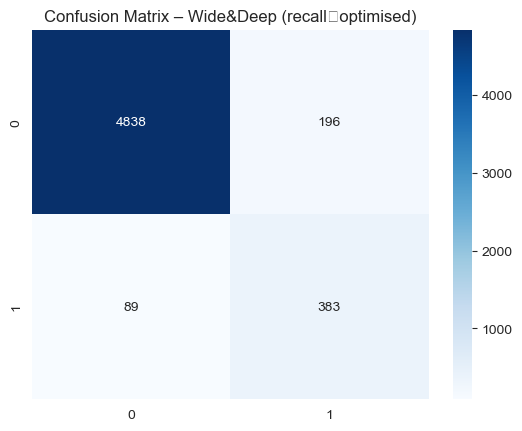


Permutation Importance (top‑8)
 HbA1c_level            0.196351
blood_glucose_level    0.089457
age                    0.029163
bmi                    0.018174
smoking_history_idx    0.000391
hypertension           0.000260
smoking_history_idx    0.000178
age_smoke_cross        0.000177
dtype: float64


  0%|          | 0/200 [00:00<?, ?it/s]

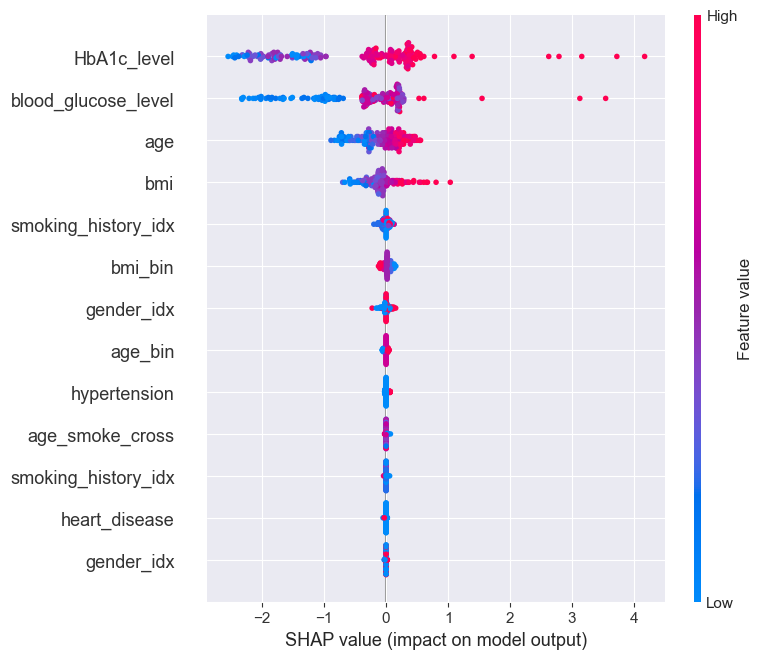


Saved: scaler.pkl, cat_mappings.pkl, best_wd.pt


In [2]:
"""
Wide & Deep Diabetes‑Prediction Pipeline
  – Train/Val/Test split, SMOTENC class balancing
  – Optuna‑tuned Wide‑&‑Deep (PyTorch) with recall‑oriented tweaks
  – Full metrics, plots, permutation importance & SHAP
  Author: Dylan Jay
"""
# ──────────────────────────────  IMPORTS  ──────────────────────────────
import warnings; warnings.filterwarnings("ignore")

from pathlib import Path
from typing   import List, Tuple

import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap, joblib
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.base             import BaseEstimator, ClassifierMixin
from sklearn.model_selection   import train_test_split
from sklearn.preprocessing     import StandardScaler
from sklearn.inspection        import permutation_importance
from sklearn.metrics           import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, mean_squared_error, confusion_matrix,
    precision_recall_curve, roc_curve
)
from imblearn.over_sampling    import SMOTENC
from tqdm import tqdm

# ─────────────────────────────  CONFIG  ──────────────────────────────
DATA_PATH   = Path(r"C:\Users\dylan\Desktop\Data Science Final\diabetes_prediction_dataset.csv")
DEVICE      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE  = 512
EPOCHS      = 20
PATIENCE    = 3
LR          = 0.0032567291741719888
DROPOUT     = 0.3776416914679301
HIDDEN_DIMS = [166, 74, 52]          # Optuna‑tuned

# recall‑oriented Focal‑Loss params
FOCAL_ALPHA = 0.50                   # ↑ weight on positives
FOCAL_GAMMA = 1.50                   # ↓ focusing for easier positives

# ─────────────────────  DATA LOADING / FE  ───────────────────────────
def load_and_fe(path: Path) -> Tuple[pd.DataFrame, List[str], List[str], List[str],
                                     pd.DataFrame, pd.DataFrame, pd.DataFrame, np.ndarray,
                                     StandardScaler, dict]:
    df = pd.read_csv(path)

    num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
    cat_cols = ['gender', 'smoking_history']
    target   = 'diabetes'

    df['age_bin'] = pd.cut(df['age'], bins=[0,20,40,60,80,100], labels=False)
    df['bmi_bin'] = pd.cut(df['bmi'], bins=[0,18.5,25,30,35,100], labels=False)

    cat_map = {}
    for col in cat_cols:
        df[col] = df[col].astype(str)
        df[f"{col}_idx"], cat_map[col] = pd.factorize(df[col])

    df['age_smoke_cross'] = df['age_bin'].astype(str) + "_" + df['smoking_history']
    df['age_smoke_cross'], _ = pd.factorize(df['age_smoke_cross'])

    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])

    wide_feats = ['hypertension','heart_disease','age_bin','bmi_bin','age_smoke_cross'] \
               + [f"{c}_idx" for c in cat_cols]
    deep_cont  = num_cols
    deep_cat   = [f"{c}_idx" for c in cat_cols]

    X_wide = df[wide_feats].astype(int)
    X_cont = df[deep_cont]
    X_cat  = df[deep_cat].astype(int)
    y      = df[target].astype(int).values

    return (df, wide_feats, deep_cont, deep_cat,
            X_wide, X_cont, X_cat, y, scaler, cat_map)

(df,
 wide_feats, deep_cont, deep_cat,
 X_wide, X_cont, X_cat, y, scaler, cat_map) = load_and_fe(DATA_PATH)

# ─────────────────────  SPLIT & SMOTENC  ────────────────────────────
X_all  = pd.concat([X_wide, X_cont, X_cat], axis=1)
X_trv, X_test, y_trv, y_test = train_test_split(X_all, y, test_size=0.2,
                                                stratify=y, random_state=42)
X_tr , X_val , y_tr , y_val  = train_test_split(X_trv, y_trv, test_size=0.2,
                                                stratify=y_trv, random_state=42)

cat_idx = list(range(len(wide_feats))) + \
          list(range(len(wide_feats)+len(deep_cont), X_all.shape[1]))
X_tr_res, y_tr_res = SMOTENC(cat_idx, random_state=42).fit_resample(X_tr, y_tr)

def split_cols(df_: pd.DataFrame):
    w, c = len(wide_feats), len(deep_cont)
    return df_.iloc[:, :w], df_.iloc[:, w:w+c], df_.iloc[:, w+c:]

Xw_tr, Xc_tr, Xcat_tr = split_cols(X_tr_res)
Xw_va, Xc_va, Xcat_va = split_cols(X_val)
Xw_te, Xc_te, Xcat_te = split_cols(X_test)

# ─────────────────────  TORCH DATASET  ──────────────────────────────
class WDDataset(Dataset):
    def __init__(self, Xw, Xc, Xcat, y):
        self.Xw   = torch.tensor(Xw.values,   dtype=torch.long)
        self.Xc   = torch.tensor(Xc.values,   dtype=torch.float32)
        self.Xcat = torch.tensor(Xcat.values, dtype=torch.long)
        self.y    = torch.tensor(y,           dtype=torch.float32)
    def __len__(self): return len(self.y)
    def __getitem__(self, i): return {
        "wide"     : self.Xw[i],  "deep_cont": self.Xc[i],
        "deep_cat" : self.Xcat[i],"target"   : self.y[i]}

train_loader = DataLoader(WDDataset(Xw_tr,Xc_tr,Xcat_tr,y_tr_res),
                          batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(WDDataset(Xw_va,Xc_va,Xcat_va,y_val),
                          batch_size=BATCH_SIZE)
test_loader  = DataLoader(WDDataset(Xw_te,Xc_te,Xcat_te,y_test),
                          batch_size=BATCH_SIZE)

# ─────────────────────  MODEL  ──────────────────────────────────────
class WideDeep(nn.Module):
    def __init__(self, w_in: int, cont_in: int, cat_card: List[int],
                 hidden: List[int]=HIDDEN_DIMS, drop: float=DROPOUT):
        super().__init__()
        self.wide = nn.Linear(w_in, 1)

        emb_dims = [min(50, (c+1)//2) for c in cat_card]
        self.emb = nn.ModuleList(nn.Embedding(c, e) for c, e in zip(cat_card, emb_dims))

        deep_in  = cont_in + sum(emb_dims)
        self.bn  = nn.BatchNorm1d(deep_in)

        layers, curr = [], deep_in
        for h in hidden:
            layers += [nn.Linear(curr, h), nn.GELU(), nn.LayerNorm(h), nn.Dropout(drop)]
            curr = h
        self.deep = nn.Sequential(*layers)
        self.out  = nn.Linear(hidden[-1], 1)

    def forward(self, w, cont, cat):
        wide_out   = self.wide(w.float())
        cat_embed  = torch.cat([emb(cat[:, i]) for i, emb in enumerate(self.emb)], dim=1)
        deep_in    = self.bn(torch.cat([cont, cat_embed], dim=1))
        deep_out   = self.deep(deep_in)
        return torch.sigmoid(self.out(deep_out) + wide_out).squeeze(1)

class FocalLoss(nn.Module):
    def __init__(self, alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA):
        super().__init__(); self.a, self.g = alpha, gamma
    def forward(self, p, y):
        bce = F.binary_cross_entropy(p, y, reduction="none")
        pt  = torch.where(y == 1, p, 1-p)
        return (self.a * (1-pt)**self.g * bce).mean()

cat_cardinals = [df[c].max() + 1 for c in deep_cat]
model     = WideDeep(len(wide_feats), len(deep_cont), cat_cardinals).to(DEVICE)
criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=2)

# ─────────────────────  EVAL HELPERS  ───────────────────────────────
def evaluate(net, loader, thr=0.5):
    net.eval(); y_true, y_prob = [], []
    with torch.no_grad():
        for b in loader:
            p = net(b["wide"].to(DEVICE),
                    b["deep_cont"].to(DEVICE),
                    b["deep_cat"].to(DEVICE))
            y_prob += p.cpu().tolist();  y_true += b["target"].tolist()
    y_prob = np.array(y_prob);   y_true = np.array(y_true)
    y_pred = (y_prob > thr).astype(int)
    cm     = confusion_matrix(y_true, y_pred)
    return {
        "auc": roc_auc_score(y_true, y_prob),
        "acc": accuracy_score(y_true, y_pred),
        "f1" : f1_score(y_true, y_pred),
        "rec": recall_score(y_true, y_pred),
        "cm" : cm,
        "y_true": y_true, "y_prob": y_prob, "y_pred": y_pred
    }

# ─────────────────────  TRAINING  ───────────────────────────────────
best_auc, wait = 0, 0
for epoch in range(1, EPOCHS+1):
    model.train(); ep_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False):
        optimizer.zero_grad()
        pred  = model(batch["wide"].to(DEVICE),
                      batch["deep_cont"].to(DEVICE),
                      batch["deep_cat"].to(DEVICE))
        loss  = criterion(pred, batch["target"].to(DEVICE)); loss.backward(); optimizer.step()
        ep_loss += loss.item()

    val = evaluate(model, val_loader)
    scheduler.step(1 - val["auc"])
    print(f"Epoch {epoch:02d} | loss {ep_loss:.2f} | AUC {val['auc']:.4f} | "
          f"Recall {val['rec']:.4f} | F1 {val['f1']:.4f}")

    if val["auc"] > best_auc:
        best_auc, wait = val["auc"], 0
        torch.save(model.state_dict(), "best_wd.pt"); print("  ↳ saved")
    else:
        wait += 1
        if wait == PATIENCE:
            print("Early‑stop"); break

# ───────────────────  THRESHOLD (F‑β β=2)  ─────────────────────────
model.load_state_dict(torch.load("best_wd.pt"))
val = evaluate(model, val_loader)

prec, rec, thr = precision_recall_curve(val["y_true"], val["y_prob"])
beta = 2
f_beta = (1 + beta**2) * prec * rec / (beta**2 * prec + rec + 1e-8)
best_thr = thr[np.argmax(f_beta)]
print(f"\nChosen threshold (max F₂) ➜ {best_thr:.3f}")

test = evaluate(model, test_loader, thr=best_thr)
fp, fn = test["cm"][0,1], test["cm"][1,0]
print("\n===  TEST METRICS (recall‑optimised) ===")
print(f"AUC   : {test['auc'] :.4f}")
print(f"Acc   : {test['acc'] :.4f}")
print(f"F1    : {test['f1']  :.4f}")
print(f"Recall: {test['rec'] :.4f}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

sns.heatmap(test["cm"], annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – Wide&Deep (recall‑optimised)"); plt.show()

# ───────────────── PERMUTATION IMPORTANCE  ─────────────────────────
class SKWrapper(BaseEstimator, ClassifierMixin):
    """Lightweight sklearn‑compatible wrapper around the PyTorch model."""
    def __init__(self, predict_func, thr=best_thr):
        self.predict_func = predict_func
        self.thr          = thr
        self.classes_     = np.array([0, 1])      

    # no‑op fit (required by sklearn)
    def fit(self, X=None, y=None): return self

    def predict_proba(self, X):
        p = self.predict_func(X).reshape(-1, 1)
        return np.hstack([1.0 - p, p])

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] > self.thr).astype(int)


wide_len, cont_len = len(wide_feats), len(deep_cont)
def wd_pred(arr):
    with torch.no_grad():
        w   = torch.tensor(arr[:, :wide_len],                  dtype=torch.long , device=DEVICE)
        con = torch.tensor(arr[:, wide_len:wide_len+cont_len], dtype=torch.float32, device=DEVICE)
        cat = torch.tensor(arr[:, wide_len+cont_len:],         dtype=torch.long , device=DEVICE)
        for i, emb in enumerate(model.emb): cat[:, i].clamp_(0, emb.num_embeddings-1)
        return model(w, con, cat).cpu().numpy()

perm_sub      = X_test.sample(n=min(1000, len(X_test)), random_state=42)
y_test_series = pd.Series(y_test, index=X_test.index) 
perm_res = permutation_importance(
    SKWrapper(wd_pred),                
    perm_sub.values,
    y_test_series.loc[perm_sub.index], 
    n_repeats=10,
    random_state=42,
    scoring="roc_auc",
)

imp = (pd.Series(perm_res.importances_mean, index=perm_sub.columns)
         .sort_values(ascending=False))
print("\nPermutation Importance (top‑8)\n", imp.head(8))

# ───────────────────────────  SHAP  ────────────────────────────────
background = X_trv.sample(100, random_state=0)
test_samp  = X_test.sample(min(200, len(X_test)), random_state=1)

explainer  = shap.KernelExplainer(wd_pred, background.values, link="logit")
shap_vals  = explainer.shap_values(test_samp.values, nsamples=200)
shap.summary_plot(shap_vals[0] if isinstance(shap_vals, list) else shap_vals,
                  features=test_samp, max_display=15)

# ─────────────────────  SAVE ARTIFACTS  ────────────────────────────
joblib.dump(scaler, "scaler.pkl")
joblib.dump(cat_map, "cat_mappings.pkl")
print("\nSaved: scaler.pkl, cat_mappings.pkl, best_wd.pt")


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import joblib
import numpy as np

# === Load Data ===
file_path = r"C:\Users\dylan\Desktop\Data Science Final\diabetes_prediction_dataset.csv"
df = pd.read_csv(file_path)

# === Feature Engineering (similar to the exploration script) ===
num_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
cat_cols = ['gender', 'smoking_history']
target_col = 'diabetes'

# Encode categorical features
cat_embed_mappings = {}
for col in cat_cols:
    df[col] = df[col].astype(str)
    df[col + '_idx'], cat_embed_mappings[col] = pd.factorize(df[col])

df['age_bin'] = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, 100], labels=False)
df['bmi_bin'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, 35, 100], labels=False)

# Normalize numerical features
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Prepare features
wide_features = ['hypertension', 'heart_disease', 'age_bin', 'bmi_bin'] + [col + '_idx' for col in cat_cols]
X_wide = df[wide_features].astype(int)
X_cont = df[num_cols]
X_cat = [col + '_idx' for col in cat_cols]
y = df[target_col].values

# === Split into Train / Validation / Test ===
X_train_val, X_test, y_train_val, y_test = train_test_split(df[wide_features + num_cols], y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42)

# === Partioning from any previous possible printed statements ===
print()

# === 1. SVM Model ===
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Predictions and Evaluation for SVM
y_pred_svm = svm_model.predict(X_test)
y_pred_svm_proba = svm_model.predict_proba(X_test)[:, 1]

svm_auc = roc_auc_score(y_test, y_pred_svm_proba)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)

print(f"SVM Model - AUC: {svm_auc:.4f}, Accuracy: {svm_accuracy:.4f}, F1 Score: {svm_f1:.4f}")

# === 2. XGBoost Model ===
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions and Evaluation for XGBoost
y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

xgb_auc = roc_auc_score(y_test, y_pred_xgb_proba)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)

print(f"XGBoost Model - AUC: {xgb_auc:.4f}, Accuracy: {xgb_accuracy:.4f}, F1 Score: {xgb_f1:.4f}")


SVM Model - AUC: 0.9628, Accuracy: 0.9651, F1 Score: 0.7618
XGBoost Model - AUC: 0.9740, Accuracy: 0.9691, F1 Score: 0.7995



================  FULL  TEST‑SET  METRICS  =================

Wide‑Deep
--------------------------------
Accuracy        : 0.9482
Precision       : 0.6615
Recall          : 0.8114
F1‑Score        : 0.7288
ROC AUC         : 0.9755
MSE (probabil.) : 0.0637
False Positives : 196
False Negatives : 89

SVM
--------------------------------
Accuracy        : 0.9651
Precision       : 0.9192
Recall          : 0.6504
F1‑Score        : 0.7618
ROC AUC         : 0.9628
MSE (probabil.) : 0.0294
False Positives : 27
False Negatives : 165

XGBoost
--------------------------------
Accuracy        : 0.9691
Precision       : 0.9016
Recall          : 0.7182
F1‑Score        : 0.7995
ROC AUC         : 0.9740
MSE (probabil.) : 0.0248
False Positives : 37
False Negatives : 133


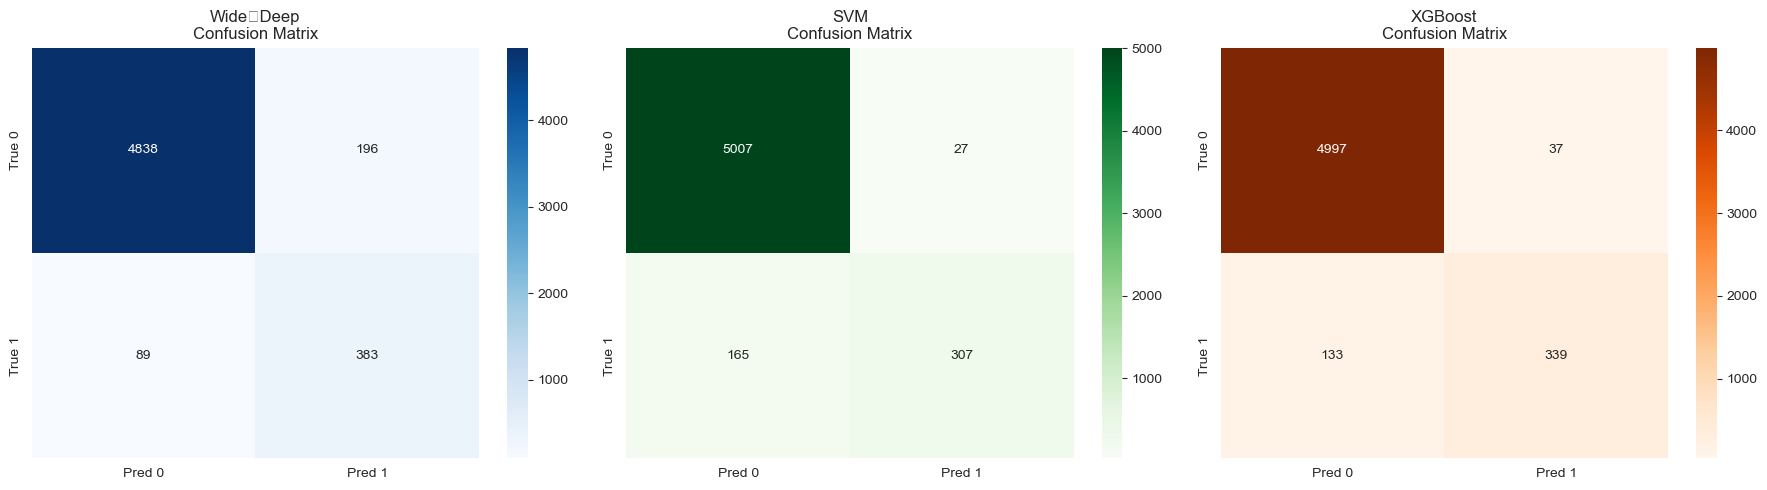

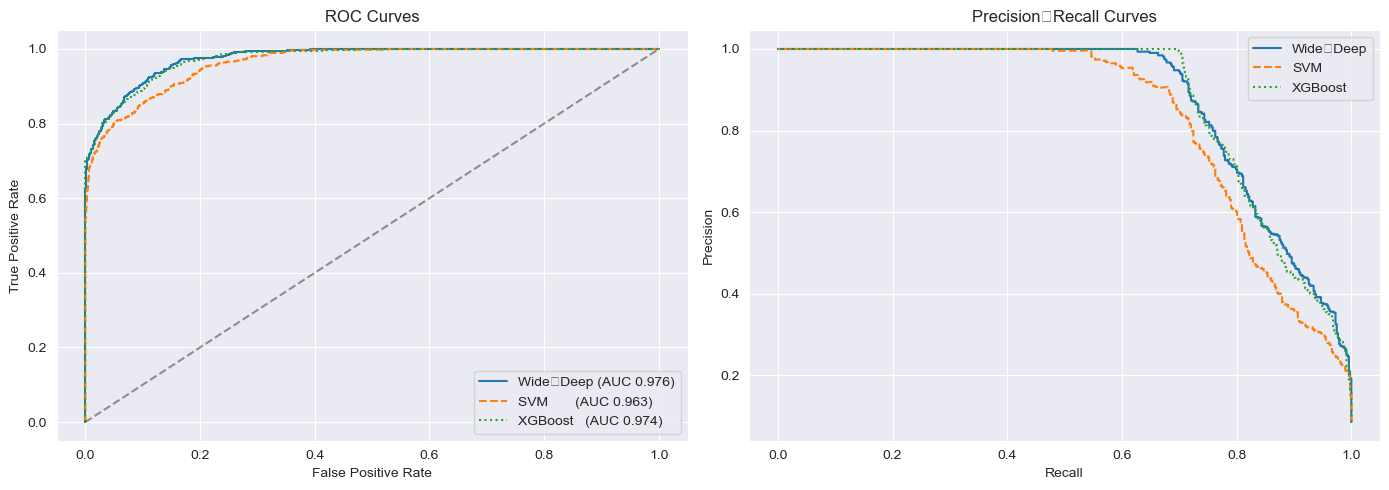

In [4]:
#Author: Dylan Jay
# ╔══════════════════  BASELINE COMPARISON – SVM & XGBoost  ══════════════════╗
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, mean_squared_error, confusion_matrix,
    roc_curve, precision_recall_curve
)

# ── 1. Retrieve Wide‑&‑Deep outputs ─────────────────────────────────────────
wd_dict = globals().get("test_out") or globals().get("test")
if wd_dict is None:
    raise RuntimeError("Cannot find W&D test dictionary. "
                       "Make sure your pipeline cell ends with a variable "
                       "named 'test' or 'test_out'.")

y_test_true = wd_dict["y_true"]
y_test_prob = wd_dict["y_prob"]
y_test_pred = wd_dict["y_pred"]           # already thresholded

# ── 2. Ensure baseline arrays are available ────────────────────────────────
need = ["y_pred_svm_proba", "y_pred_xgb_proba"]
missing = [v for v in need if v not in globals()]
if missing:
    raise RuntimeError(
        "Missing baseline variables: " + ", ".join(missing) +
        "\n→ Run (or reload) the SVM / XGBoost baseline cell first."
    )

best_thr = globals().get("best_thr", 0.50)
y_pred_svm = globals().get("y_pred_svm",
                           (y_pred_svm_proba  > best_thr).astype(int))
y_pred_xgb = globals().get("y_pred_xgb",
                           (y_pred_xgb_proba > best_thr).astype(int))

# ── 3. Metric helper ───────────────────────────────────────────────────────
def metrics(y_true, prob, pred):
    cm = confusion_matrix(y_true, pred)
    return dict(
        acc  = accuracy_score (y_true, pred),
        prec = precision_score(y_true, pred, zero_division=0),
        rec  = recall_score   (y_true, pred, zero_division=0),
        f1   = f1_score       (y_true, pred, zero_division=0),
        auc  = roc_auc_score  (y_true, prob),
        mse  = mean_squared_error(y_true, prob),
        cm   = cm,
        fp   = cm[0, 1],
        fn   = cm[1, 0],
    )

wd   = metrics(y_test_true, y_test_prob,  y_test_pred)
svm  = metrics(y_test,      y_pred_svm_proba,  y_pred_svm)
xgb  = metrics(y_test,      y_pred_xgb_proba,  y_pred_xgb)

# ── 4. Console table ───────────────────────────────────────────────────────
print("\n================  FULL  TEST‑SET  METRICS  =================")
for name, m in [("Wide‑Deep", wd), ("SVM", svm), ("XGBoost", xgb)]:
    print(f"\n{name}")
    print("-"*32)
    print(f"Accuracy        : {m['acc'] :.4f}")
    print(f"Precision       : {m['prec']:.4f}")
    print(f"Recall          : {m['rec'] :.4f}")
    print(f"F1‑Score        : {m['f1']  :.4f}")
    print(f"ROC AUC         : {m['auc'] :.4f}")
    print(f"MSE (probabil.) : {m['mse'] :.4f}")
    print(f"False Positives : {m['fp']}")
    print(f"False Negatives : {m['fn']}")

# ── 5‑A Confusion‑matrix heat‑maps ────────────────────────────────────────
plt.figure(figsize=(18, 5))
for i, (ttl, m, cmap) in enumerate(zip(
        ["Wide‑Deep", "SVM", "XGBoost"],
        [wd,          svm,   xgb],
        ["Blues",     "Greens", "Oranges"])):
    plt.subplot(1, 3, i+1)
    sns.heatmap(m["cm"], annot=True, fmt="d", cmap=cmap,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(f"{ttl}\nConfusion Matrix")
plt.tight_layout(); plt.show()

# ── 5‑B ROC & Precision‑Recall curves ──────────────────────────────────────
# ROC
wd_fpr,  wd_tpr,  _ = roc_curve(y_test_true, y_test_prob)
svm_fpr, svm_tpr, _ = roc_curve(y_test,      y_pred_svm_proba)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test,      y_pred_xgb_proba)

# PR
wd_prec,  wd_rec,  _ = precision_recall_curve(y_test_true, y_test_prob)
svm_prec, svm_rec, _ = precision_recall_curve(y_test,      y_pred_svm_proba)
xgb_prec, xgb_rec, _ = precision_recall_curve(y_test,      y_pred_xgb_proba)

plt.figure(figsize=(14, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(wd_fpr, wd_tpr, label=f"Wide‑Deep (AUC {wd['auc'] :.3f})")
plt.plot(svm_fpr, svm_tpr, label=f"SVM       (AUC {svm['auc']:.3f})", ls="--")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost   (AUC {xgb['auc']:.3f})", ls=":")
plt.plot([0, 1], [0, 1], "k--", alpha=0.4)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves"); plt.legend()

# PR
plt.subplot(1, 2, 2)
plt.plot(wd_rec,  wd_prec,  label="Wide‑Deep")
plt.plot(svm_rec, svm_prec, label="SVM",     ls="--")
plt.plot(xgb_rec, xgb_prec, label="XGBoost", ls=":")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision‑Recall Curves"); plt.legend()

plt.tight_layout(); plt.show()
